In [1]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import cmath as cm
import torch
import math

# Task 1: maximum likelihood fit (3 points)

Let's generate a Gaussian mixture dataset and then fit its parameters with maximum likelihood.

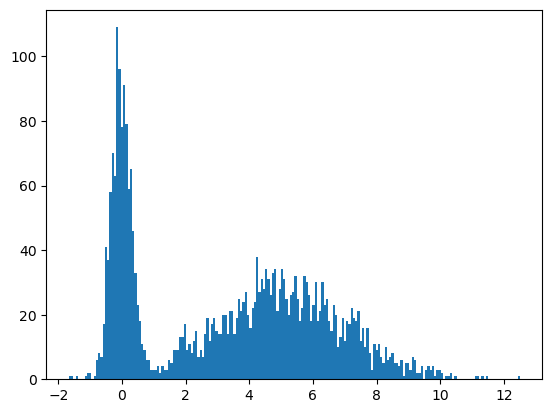

In [2]:
X1 = np.random.normal(size = 1000, scale = 0.3).astype('float32')
X2 = np.random.normal(size = 2000, loc = 5., scale = 2.).astype('float32')

X = np.concatenate([X1, X2])
np.random.shuffle(X)

plt.hist(X, bins = 200);

**Task**:
 - fill the gaps below to perform the max. likelihood fit with the pdf:
$$\text{PDF}(x|\mu_1, \sigma^2_1, \mu_2, \sigma^2_2, \alpha)
= \alpha\cdot\mathscr{N}(x|\mu_1, \sigma_1^2) + (1 - \alpha)\cdot\mathscr{N}(x|\mu_2, \sigma_2^2)$$
 - what the fitted values of $\mu_1, \sigma^2_1, \mu_2, \sigma^2_2$ and $\alpha$ should be? does your fit converge to them?

Defining Gaussian PDF using torch functions

$$
f(x) = \frac{1}{\sigma \sqrt{2\pi} } e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2}
$$

In [3]:
def gaussian(x, mu, sigma):
    pdf = 1 / torch.sqrt(torch.square(sigma) * 2 * torch.tensor(np.pi)) \
    * torch.exp(-torch.square(x - mu) / (2 * torch.square(sigma)))
    return pdf

Arbitrary mixture PDF

In [4]:
def mixture(x, f1, f2, alpha):
    return alpha * f1(x) + (1. - alpha) * f2(x)

At each gradient update we'll apply this function to ensure valid parameter values

In [5]:
def apply_constraints():
    with torch.no_grad():
        s1.clamp(min = 1e-5)
        s2.clamp(min = 1e-5)
        alpha.clamp(min = 0, max = 1)

Defining the overall PDF

In [6]:
def model_pdf(x):
  return mixture(x,
                 lambda t: gaussian(t, m1, s1),
                 lambda t: gaussian(t, m2, s2),
                 alpha)

Log likelihood

In [7]:
def loglike(x):
    return torch.sum(torch.log(model_pdf(x)))

Parameters that we'd like to infer (with an initial guess)

In [8]:
m1    = torch.tensor([1.0])
m2    = torch.tensor([4.0])
s1    = torch.tensor([1.0])
s2    = torch.tensor([1.0])
alpha = torch.tensor([0.5])
X     = torch.tensor(X)

variables = [m1, m2, s1, s2, alpha]
for i in variables:
    i.requires_grad = True

learning_rate = 0.0001
grad_history = []

Let's increase the step for clarity of the graphs

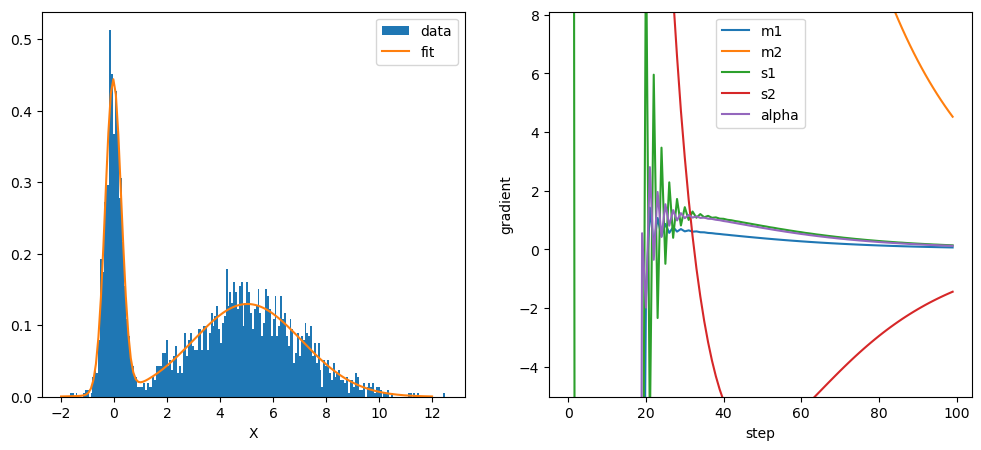

In [9]:
for i in range(100):

    for i in variables:
        if i.grad is not None: i.grad.zero_()

    # Forward pass:
    l = loglike(X)

    # Backprop
    l.backward()

    # Gradient ascent step
    with torch.no_grad():
        for i in variables:
            i += i.grad * learning_rate

    apply_constraints()

    grad_history.append([i.grad.item() for i in variables])

    # Do some plotting
    plt.figure(figsize = (12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(X.detach().numpy(), bins = 200, density = True, label = 'data')
    x_grid = torch.linspace(-2, 12, 150)
    plt.plot(x_grid, model_pdf(x_grid).detach().numpy(), label = 'fit')
    plt.legend()
    plt.xlabel('X')

    plt.subplot(1, 2, 2)
    lines = plt.plot(np.array(grad_history))
    low = min(grad_history[-1])
    high = max(grad_history[-1])
    plt.ylim(low  - (high - low) * 0.6,
             high + (high - low) * 0.6)
    plt.legend(lines, ['m1', 'm2', 's1', 's2', 'alpha'])
    plt.xlabel('step')
    plt.ylabel('gradient')
    plt.show()
    clear_output(wait = True);

In [10]:
m1

tensor([-0.0304], requires_grad=True)

In [11]:
m2

tensor([5.0308], requires_grad=True)

In [12]:
s1

tensor([0.3038], requires_grad=True)

In [13]:
s2

tensor([2.0498], requires_grad=True)

In [14]:
alpha

tensor([0.3335], requires_grad=True)

Значения параметров $\mu_1, \mu_2, \sigma^2_1, \sigma^2_2, \alpha$ должны сходиться к заданным значениям параметров исходных гауссиан:

$\mu_1 = 0.0, \mu_2 = 5.0, \sigma^2_1 = 0.3, \sigma^2_2 = 2.0,$

$\alpha = \frac{1}{3},$ так как это вероятность того, что с. в. принадлежит одной из исходных гауссиан, в данном случае гауссиане с 1000 из 3000 наблюдений.

Полученные значения действительно сходятся к исходным значениям.

# Task 2: classifying clothes (3 points)

Download and load the training data

In [15]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))
                               ])

trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)

[['Pullover' 'Bag' 'Bag' 'Coat' 'Dress' 'Sneaker' 'Sandal' 'T-shirt/top']
 ['Ankle boot' 'Coat' 'Shirt' 'Trouser' 'Ankle boot' 'Pullover' 'Coat'
  'Shirt']
 ['Sandal' 'Shirt' 'Ankle boot' 'Coat' 'Sneaker' 'Dress' 'Shirt'
  'Sneaker']
 ['Dress' 'Sneaker' 'Ankle boot' 'Ankle boot' 'Coat' 'Shirt' 'Dress'
  'Shirt']
 ['Sneaker' 'Shirt' 'T-shirt/top' 'Ankle boot' 'Shirt' 'Coat' 'Bag'
  'T-shirt/top']
 ['Trouser' 'Bag' 'Bag' 'Sneaker' 'Coat' 'Dress' 'Bag' 'Sandal']
 ['Trouser' 'Shirt' 'Sneaker' 'T-shirt/top' 'Shirt' 'Sneaker' 'Sandal'
  'Pullover']
 ['Dress' 'Pullover' 'Coat' 'Shirt' 'T-shirt/top' 'Dress' 'Coat'
  'T-shirt/top']]


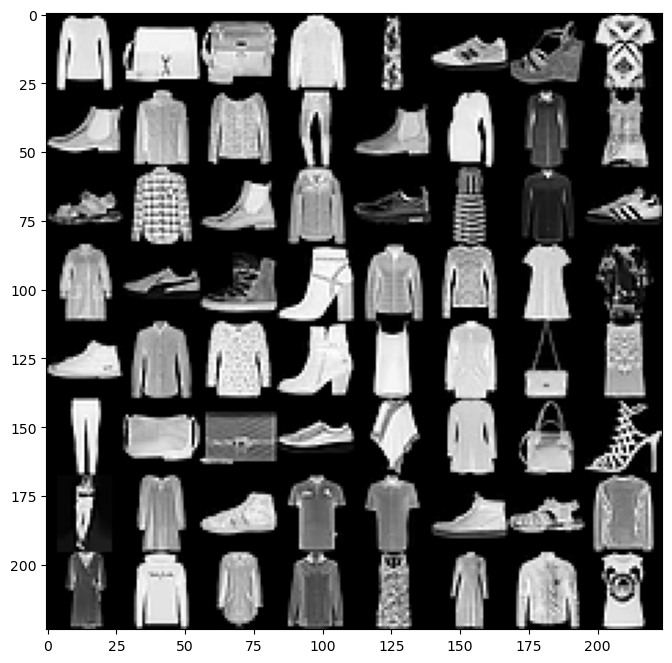

In [16]:
# Array for decoding the categories
label_names = np.array(['T-shirt/top',
                        'Trouser',
                        'Pullover',
                        'Dress',
                        'Coat',
                        'Sandal',
                        'Shirt',
                        'Sneaker',
                        'Bag',
                        'Ankle boot'])

# Get a single data batch of 64 images
sample_images, sample_labels = next(iter(trainloader))

# Plot the images in a 8x8 grid
plt.figure(figsize=(8, 8))
plt.imshow(
    sample_images.numpy().reshape(8, 8, 28, 28).transpose((0, 2, 1, 3)).reshape(224, 224),
    cmap='gray'
)
# Print corresponding labels
print(label_names[sample_labels.numpy().reshape(8, 8)])

**Task**:

Train a model which is an average of two models with different numbers of layers on the Fashion MNIST dataset, e.g.:

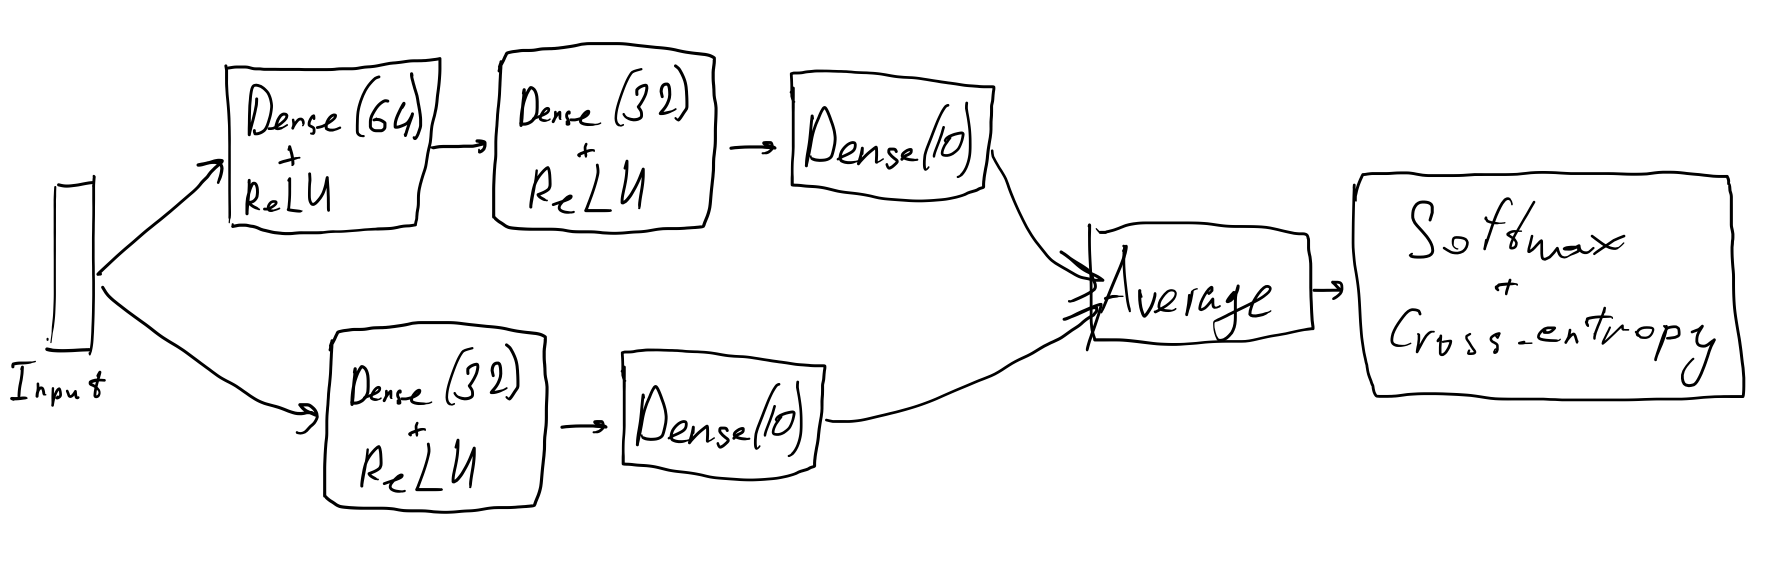

In [17]:
from tqdm.notebook import tqdm
import torch.nn as nn

gpu = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class modelC(nn.Module):
    def __init__(self, inputs):
        super(modelC, self).__init__()

        self.modelA = nn.Sequential(
            nn.Linear(inputs, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )

        self.modelB = nn.Sequential(
            nn.Linear(inputs, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )

    def forward(self, x):
        x1 = self.modelA(x)
        x2 = self.modelB(x)
        avg = torch.mean(torch.stack([x1, x2], dim = 0), dim = 0)
        return avg

model = modelC(28 ** 2)
model.to(gpu)

n = 40
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.8)

for i in tqdm(range(1, n + 1)):

    for X_train, y_train in trainloader:

        X_train = X_train.flatten(1, -1).to(gpu)
        y_train = y_train.to(gpu)

        optimizer.zero_grad()
        loss = criterion(model(X_train), y_train)
        loss.backward()
        optimizer.step()

model.eval()

predicted = []
actual = []

for X_test, y_test in testloader:

    X_test = X_test.flatten(1, -1).to(gpu)
    y_test = y_test.to(gpu)

    predicted.extend(torch.argmax(model(X_test), dim = 1).tolist())
    actual.extend(y_test)

  0%|          | 0/40 [00:00<?, ?it/s]

In [18]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, _ = precision_recall_fscore_support(actual, predicted, average = 'weighted')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'fscore: {fscore}')

precision: 0.8845751310946672
recall: 0.8834
fscore: 0.8827498459246564


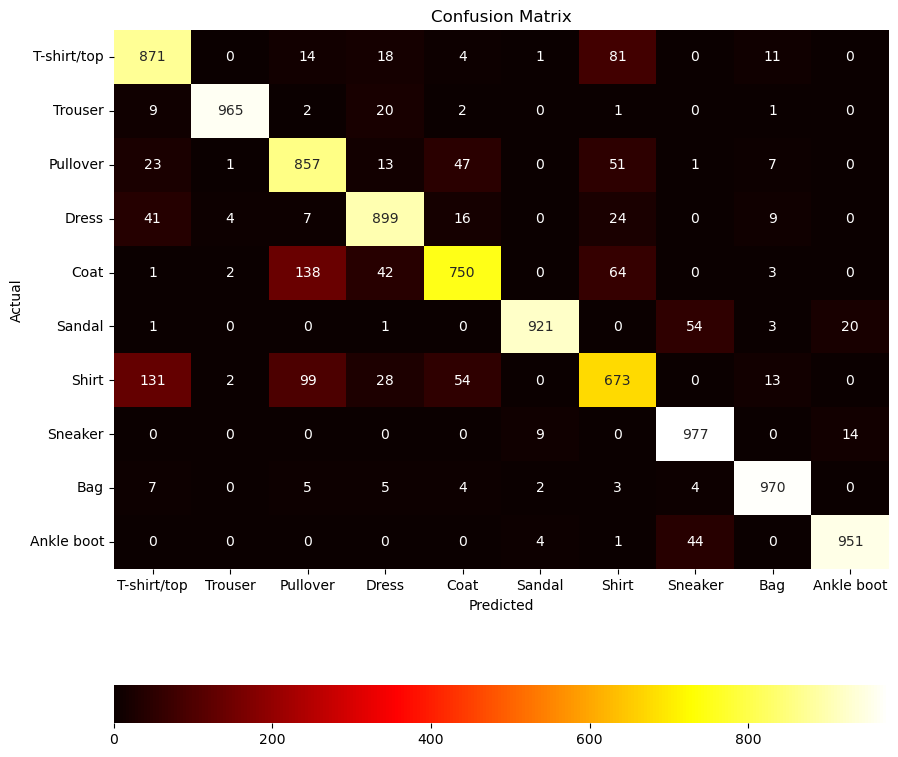

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
fig, ax = plt.subplots(figsize = (10, 10))
plt.title('Confusion Matrix')
hmap = sns.heatmap(confusion_matrix(actual, predicted, labels = np.arange(10)),
                   annot = True, fmt = 'g', cbar_kws = {'orientation': 'horizontal'},
                   xticklabels = label_names, yticklabels = label_names, cmap = 'hot')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()